# 📊 View as a histogram

In [ ]:
#| default_exp repr_plt

In [ ]:
# |hide
from nbdev.showdoc import *
from fastcore.test import test_eq, is_close

In [ ]:
# |export
# |hide
import math
from functools import cached_property
from typing import Union, Tuple, Any, Optional as O

import numpy as np
from matplotlib import pyplot as plt, axes, figure, rc_context
from IPython.core.pylabtools import print_figure

from lovely_numpy.repr_str import lovely, pretty_str
from lovely_numpy.utils import get_config, config

In [ ]:
# |hide
# |exporti
def normal_pdf( x   :np.ndarray,
                mean:Union[np.ndarray, float] =0.,
                std :Union[np.ndarray, float] =1.):
    r"""Probability Distribution Function of Normal Distribution:
        $$f(x, \mu, \sigma)
        = \dfrac{1}
            {\sigma \sqrt{2\pi} }
        e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^{2}}
        = \dfrac{e^{- \frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}}
            {\sigma \sqrt{2\pi}}$$"""

    np.e
    # dev = x.device
    
    mean = np.array(mean) #if not isinstance(mean, torch.Tensor) else mean
    std = np.array(std) #.to(dev) if not isinstance(std, torch.Tensor) else std

    return (np.array(np.e) ** ( -0.5 * ((x - mean)/std) ** 2 ) /
                (std * np.sqrt((np.pi * 2)))
            )

In [ ]:
# |hide
# |eval: false

import scipy
x = np.arange(-4, 4, 0.01)
y1 = np.array(scipy.stats.norm.pdf(x, 2, 3))
y2 = normal_pdf(x, 2, 3)

y1, y2
test_eq(is_close(y1, y2), True)

In [ ]:
# |exporti

def sample( x       :np.ndarray,
            max_s   :int,
            plt0    :bool):

    # Samples up to max_s elements and returns
    #   - samples from x
    #   - original x min (None = no good numbes in x)
    #   - original x max (None = no good numbes in x)
    
    # Ignore NaN and Inf.
    x = x[ np.isfinite(x) ]

    x_min = x_max = None

    if x.size: 
        x_min, x_max = x.min(), x.max()
        
        # An option to ignore zeros
        if not plt0: x = x[x != 0.]

        if x.size > max_s and max_s > 0:
            rng = np.random.default_rng( get_config().plt_seed )
            x = rng.choice(x.reshape(-1), max_s) # Sample with replacement for efficiency

    return (x, x_min, x_max)  

In [ ]:
# |exporti

def find_xlims( x_min   :Union[float, None],
                x_max   :Union[float, None],
                x_mean  :Union[float, None],
                x_std   :Union[float, None],
                center  :str):

    assert center in ["zero", "mean", "range"]
    
    if x_min is None or x_max is None: return (-1., 1,)
    if x_min == x_max and center == "range": center = "zero"
    if x_mean is None or x_std is None and center == "mean": center = "zero"

    # Center the plot around zero, mean, or the extents of the range of t.
    if center == "range":
        # Center plot arounf the full range of x
        xlim_min, xlim_max = x_min, x_max
    elif center == "mean":
        assert x_mean is not None
        # Center the plot around mean
        # Max distance between mean value and x_min / x_max
        max_div = max(abs(x_mean - x_min), abs(x_max - x_mean))

        xlim_min = x_mean - max_div
        xlim_max = x_mean + max_div
    else: # center == "zero"
        # Center the plot around zero
        abs_max_value = max(abs(x_min), abs(x_max), 1.)
        xlim_min, xlim_max = -abs_max_value, abs_max_value
    

    # Give some extra space around the 
    xlim_min -= abs(xlim_max - xlim_min) * 0.02
    xlim_max += abs(xlim_max - xlim_min) * 0.02

    return (xlim_min, xlim_max)

In [ ]:
# |exporti
def plot_histogram( x   :np.ndarray,
                    ax  :axes.Axes):
    if x.size:
        # Around 50 items / bin seems to look good.
        # But don't go below 10 or above 100.
        bins = int(x.size / 50)

        # Adjust the number of bins proportional to the fraction of x axis occupied
        # by the histogram
        xlims = ax.get_xlim()
        
        bins = min(bins, 100)
        bins = np.ceil( bins * ( (x.max()-x.min())/(xlims[1]-xlims[0]) ) ).astype(int)
        bins = max(bins, 10)

        ax.hist(x, bins=bins, color="deepskyblue", align="mid", density=True, zorder=4)

In [ ]:
# |exporti
def plot_pdf(   x_mean  :Union[float, None],
                x_std   :Union[float, None],
                ax      :axes.Axes):
    # PDF of normal distribution with the same mean and std.

    if x_std: # Not None and not 0.
        assert x_mean is not None
        xlims = ax.get_xlim()
        xl = np.linspace(*xlims, 100)
        # normal_density = normal_pdf(xl, mean=x_mean, std=x_std)
        ax.plot(xl, normal_pdf(xl, mean=x_mean, std=x_std), zorder=5)


In [ ]:
# |exporti
def plot_sigmas(x_min   :Union[float, None],
                x_max   :Union[float, None],
                x_mean  :Union[float, None],
                x_std   :Union[float, None],
                ax      :axes.Axes):
    if x_min is not None and x_max is not None and x_std:
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        # Make text bank part of the line under it
        bbox = dict(boxstyle="round", fc="white", edgecolor="none")
        sigmas = max(int(math.floor((abs(x_mean - x_min) / x_std))),
                    int(math.floor((abs(x_max - x_mean) / x_std))))

        for s in range(-sigmas, sigmas+1):
            x_pos = (x_mean + s*x_std)
            if xlims[0] < x_pos < xlims[1]:
                greek = ["-σ", "μ", "+σ"][s+1]  if -1 <= s <= 1 else f"{s:+}σ"
                weight='bold' if not s else None
                ax.axvline(x_pos, 0, 1, c="black")
                ax.text(x_pos, ylims[1]*0.95, greek, ha="center", va="top", bbox=bbox, zorder=5, weight=weight)


In [ ]:
# |exporti
def plot_minmax(x_min   :Union[float, None],
                x_max   :Union[float, None],
                ax      :axes.Axes):
    if x_min is not None and x_max is not None:
        bbox = dict(boxstyle="round", fc="white", edgecolor="none", pad=0.)
        y_max = ax.get_ylim()[1]

        # 2 red lines for min and max values
        ax.annotate(
            f"min={pretty_str(x_min)}",
            (x_min, y_max/2),
            xytext=(-1, 0), textcoords='offset points',
            bbox=bbox,
            rotation=90,
            ha="right",
            va="center"
            )

        ax.annotate(
            f"max={pretty_str(x_max)}",
            (x_max, y_max/2),
            xytext=(2, 0), textcoords='offset points',
            bbox=bbox,
            rotation=90,
            ha="left",
            va="center"
            )

        ax.axvline(x_min, 0, 1, c="red", zorder=2)
        ax.axvline(x_max, 0, 1, c="red", zorder=2)


In [ ]:
# |exporti
def plot_str(t_str, ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0], ylim[1]*1.05, s=t_str)

In [ ]:
# |exporti

def fig_plot(   x     :np.ndarray,  # 
                center  :str    ="zero",        # Center plot on  `zero`, `mean`, or `range`
                max_s   :int    =10000,         # Draw up to this many samples. =0 to draw all
                plt0    :Any    =True,          # Take zero values into account
                ax      :O[axes.Axes]=None,     # Optionally, supply your own matplotlib axes.
                summary :O[str] =None,          # Summary string (to display on top). None=str(lovely(x))
                ddof    :int    =0,             # Apply bias correction to std
        ) -> figure.Figure:
    """Plot statistics"""

    # Useful when you call `plot` from `lovely-tensors`/`-jax` and want to
    # display backend-specific info.
    if summary is None: summary = str(lovely(x, color=False))
    orig_numel = x.size
   
    x, x_min, x_max = sample(x, max_s, plt0)
    x_mean, x_std = (x.mean(), x.std(ddof=ddof)) if x.size else (None,None)


    t_str = ""
    if x.size != orig_numel:
        t_str += str(x.size) 
        if not plt0: t_str += " non-zero"
        t_str += f" samples (μ={pretty_str(x_mean)}, σ={pretty_str(x_std)}) of "
    t_str += summary

    cfg = get_config()
    close = cfg.fig_close and not cfg.fig_show # Don't close if requested to show
    show = cfg.fig_show and ax is None # Don't show the figure if axes was provided

    if not ax:
        fig, ax = plt.subplots(figsize=(12, 2))
        fig.set_constrained_layout(True)
        if close: plt.close(fig)

    xlims = find_xlims(x_min, x_max, x_mean, x_std, center)
    ax.set_xlim(*xlims)
    plot_histogram(x,  ax)
    plot_pdf(x_mean, x_std, ax)
    
    # Add extra space to make sure the labels clear the histogram
    ylim = ax.get_ylim()
    ax.set_ylim( ylim[0], ylim[1]*1.3 )

    plot_sigmas(x_min, x_max, x_mean, x_std, ax)
    plot_minmax(x_min, x_max, ax)
    plot_str(t_str, ax)
    
    ax.set_yticks([])

    if show: plt.show()

    return ax.figure


In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.
# Gives the ability to call both .plt and .plt(ax=ax).  

class PlotProxy(): 
    """Flexible `PIL.Image.Image` wrapper"""

    def __init__(self, x:np.ndarray):
        self.x = x
        self.params = dict( center="zero",
                            max_s=10000,
                            plt0=True,
                            ddof=0,
                            ax=None)

    def __call__(   self,
                    center  :O[str] =None,
                    max_s   :O[int] =None,
                    plt0    :Any    =None,
                    ddof    :O[int] =None,
                    ax      :O[axes.Axes]=None):

        self.params.update( { k:v for
                    k,v in locals().items()
                    if k != "self" and v is not None } )
        
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        return fig_plot( self.x, **self.params)

    def _repr_png_(self):
        return print_figure(self.fig, fmt="png",
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})

    def _repr_svg_(self):
        # Metadata and context for a mode deterministic svg generation
        metadata={
            "Date": None,
            "Creator": "Matplotlib, https://matplotlib.org/",
        }
        with rc_context({"svg.hashsalt": "1"}):
            svg_repr = print_figure(self.fig, fmt="svg", metadata=metadata)
        return svg_repr

In [ ]:
# |export

def plot(   x       :np.ndarray,        # Your data
            center  :str    ="zero",    # Center plot on  `zero`, `mean`, or `range`
            max_s   :int    =10000,     # Draw up to this many samples. =0 to draw all
            plt0    :Any    =True,      # Take zero values into account
            ax      :O[axes.Axes]=None, # Optionally, supply your own matplotlib axes.
            ddof    :int    =0,         # Apply bias correction to std
        ) -> PlotProxy:

    args = locals()
    del args["x"]

    return PlotProxy(x)(**args)

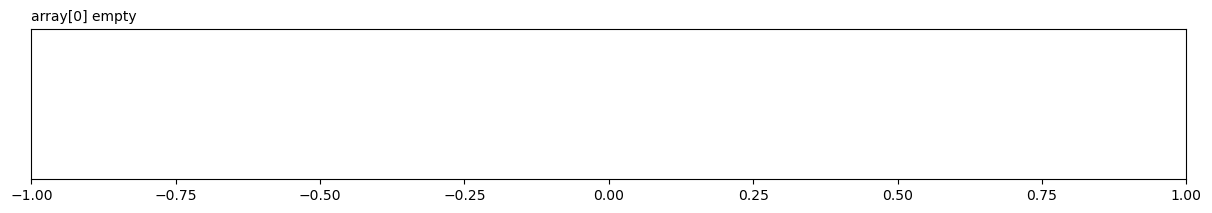

In [ ]:
plot(np.array([]))

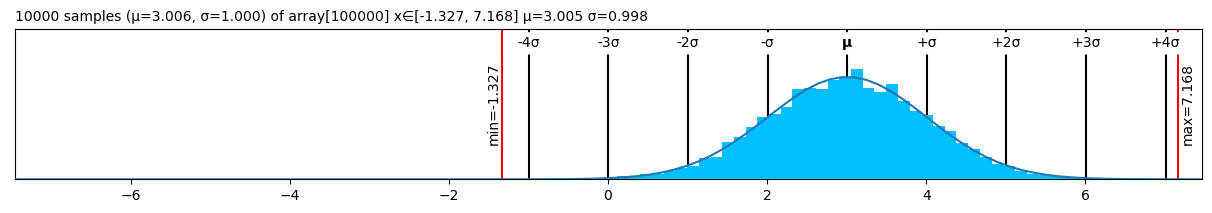

In [ ]:
np.random.seed(1)
x = np.random.randn(100000)+3
plot(x)

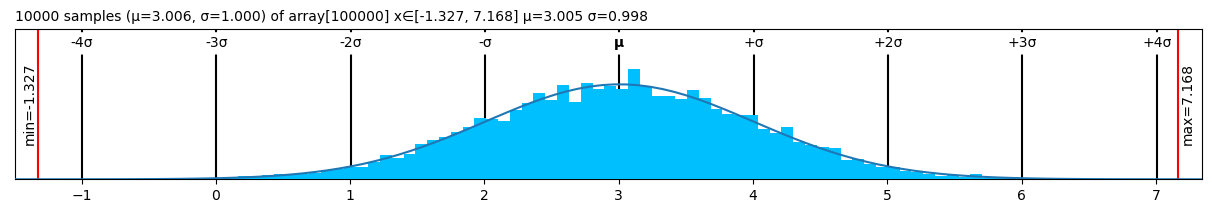

In [ ]:
plot(x, center="range")

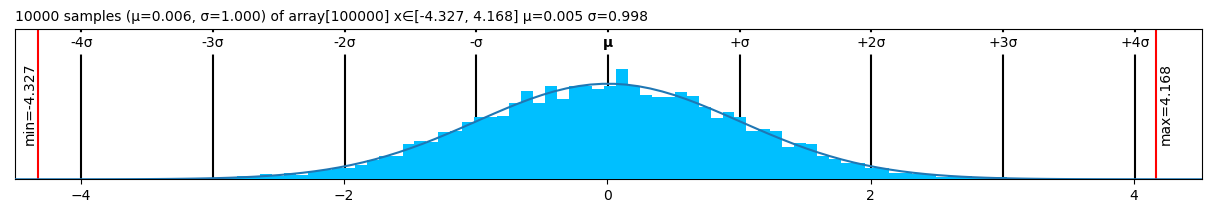

In [ ]:
plot(x-3, center="mean")

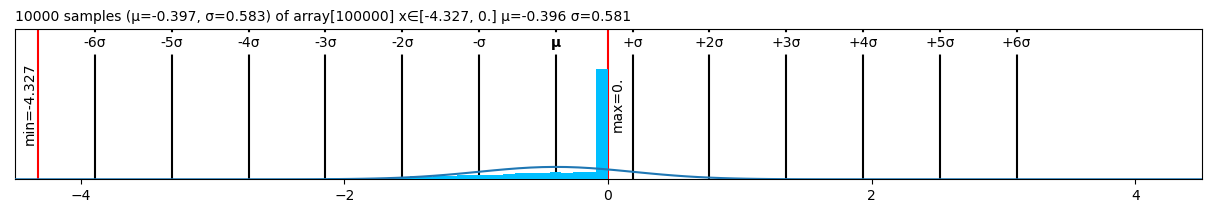

In [ ]:
plot(np.minimum(x-3, 0))

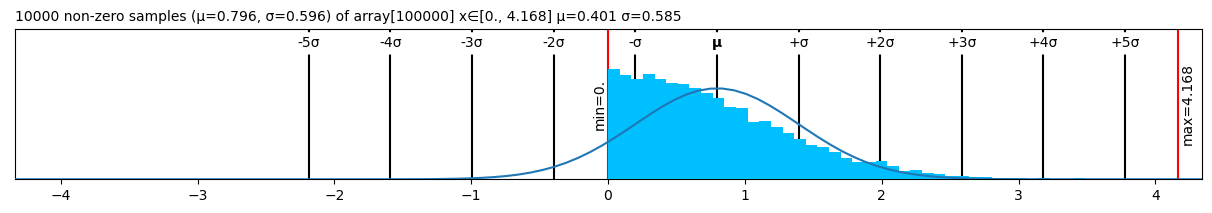

In [ ]:
plot(np.maximum(x-3, 0), plt0=0)

In [ ]:
# |hide
import matplotlib

In [ ]:
# |hide
matplotlib.rcParams["svg.hashsalt"] = "1"
%config InlineBackend.print_figure_kwargs = {'metadata': {"Date": None, "Creator": "Matplotlib, https://matplotlib.org/" }}

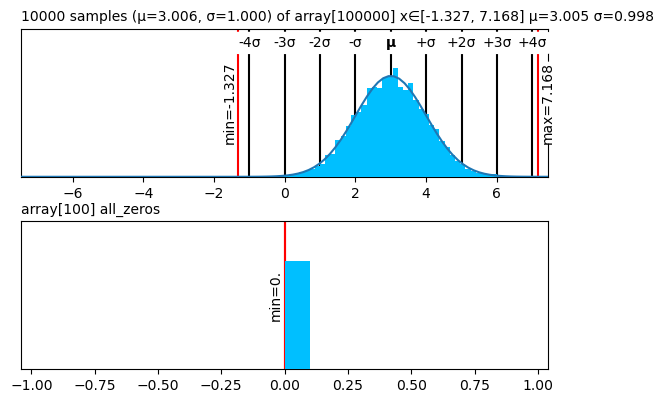

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, figsize=(6, 4))
fig.tight_layout()
plot(x, ax=ax1)
plot(np.zeros(100), ax=ax2);

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()